<a href="https://colab.research.google.com/github/GRUPO-7-SISTEMAS-DE-INFORMACION/PROCESO---ETL---G7/blob/main/SRI_Extractor_Modular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install selenium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.2/499.2 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.14.0
    Uninstalling typing_extensions-4.14.0:
      Successfully uninstalled typing_extensions-4.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
typeguard 4.4.3 requires typing_extensions>=4.14.0, but you have typing-extensions 4.13.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and pla

In [9]:

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
import time
import tempfile
import shutil
import os
import requests
def obtener_enlaces_csv(url="https://www.sri.gob.ec/datasets#Ventas%20-%20Compras"):
    opciones = webdriver.ChromeOptions()
    opciones.add_argument('--headless')
    opciones.add_argument('--no-sandbox')
    opciones.add_argument('--disable-dev-shm-usage')

    temp_dir = tempfile.mkdtemp()
    opciones.add_argument(f'--user-data-dir={temp_dir}')

    servicio = Service()
    driver = webdriver.Chrome(service=servicio, options=opciones)

    enlaces_csv = []

    try:
        driver.get(url)

        for _ in range(10):
            ActionChains(driver).send_keys(Keys.PAGE_DOWN).perform()
            time.sleep(1)

        time.sleep(5)

        links = driver.find_elements(By.XPATH, "//a[contains(@href, '.csv')]")

        for link in links:
            href = link.get_attribute("href")
            if href and href.endswith(".csv") and href not in enlaces_csv:
                enlaces_csv.append(href)


        print(f"✅ Se encontraron {len(enlaces_csv)} enlaces CSV.")
        return enlaces_csv

    except Exception as e:
        print("❌ Error durante el scraping:", e)
        return []

    finally:
        driver.quit()
        shutil.rmtree(temp_dir)


In [10]:

def descargar_archivos_sri(enlaces_csv, carpeta_destino="data"):
    print("📁 Descargando archivos...")
    os.makedirs(carpeta_destino, exist_ok=True)

    for enlace in enlaces_csv:
        nombre_archivo = os.path.basename(enlace)

        if nombre_archivo.startswith("sri_ventas") and nombre_archivo.endswith(".csv"):
            ruta_destino = os.path.join(carpeta_destino, nombre_archivo)

            if not os.path.exists(ruta_destino):
                print(f"⬇️ Descargando: {nombre_archivo}")
                try:
                    response = requests.get(enlace)
                    response.raise_for_status()
                    with open(ruta_destino, "wb") as f:
                        f.write(response.content)
                    print(f"✅ Guardado en: {ruta_destino}")
                except Exception as e:
                    print(f"❌ Error al descargar {nombre_archivo}: {e}")
            else:
                print(f"⚠️ Ya existe: {nombre_archivo}, se omite descarga.")


In [12]:
enlaces = obtener_enlaces_csv()
print("🔗 Enlaces encontrados:")
for e in enlaces:
    print(e)

descargar_archivos_sri(enlaces)


✅ Se encontraron 93 enlaces CSV.
🔗 Enlaces encontrados:
https://descargas.sri.gob.ec/download/datosAbiertos/SRI_RUC_Azuay.csv
https://descargas.sri.gob.ec/download/datosAbiertos/SRI_RUC_Bolivar.csv
https://descargas.sri.gob.ec/download/datosAbiertos/SRI_RUC_Ca%C3%B1ar.csv
https://descargas.sri.gob.ec/download/datosAbiertos/SRI_RUC_Carchi.csv
https://descargas.sri.gob.ec/download/datosAbiertos/SRI_RUC_Cotopaxi.csv
https://descargas.sri.gob.ec/download/datosAbiertos/SRI_RUC_Chimborazo.csv
https://descargas.sri.gob.ec/download/datosAbiertos/SRI_RUC_El_Oro.csv
https://descargas.sri.gob.ec/download/datosAbiertos/SRI_RUC_Esmeraldas.csv
https://descargas.sri.gob.ec/download/datosAbiertos/SRI_RUC_Galapagos.csv
https://descargas.sri.gob.ec/download/datosAbiertos/SRI_RUC_Imbabura.csv
https://descargas.sri.gob.ec/download/datosAbiertos/SRI_RUC_Loja.csv
https://descargas.sri.gob.ec/download/datosAbiertos/SRI_RUC_Los_Rios.csv
https://descargas.sri.gob.ec/download/datosAbiertos/SRI_RUC_Manabi.csv
ht

In [16]:
import pandas as pd
import os
import glob

# 1. Crear carpeta CSV_unido si no existe
os.makedirs("CSV_unido", exist_ok=True)

# 2. Buscar todos los CSV en la carpeta "data/"
csv_files = glob.glob("data/sri_ventas*.csv")

# 3. Leer y concatenar todos los CSV encontrados
dataframes = []
for file in csv_files:
    try:
        df = pd.read_csv(file, encoding='latin1', sep='|', low_memory=False)
        df.head()
        dataframes.append(df)
        print(f"✅ Archivo agregado: {file}")
    except Exception as e:
        print(f"❌ Error al procesar {file}: {e}")

# 4. Unir todos los DataFrames
if dataframes:
    df_unido = pd.concat(dataframes, ignore_index=True)

    # 5. Guardar el archivo unido
    ruta_salida = "CSV_unido/sri_ventas_unido.csv"
    df_unido.to_csv(ruta_salida, index=False, encoding='utf-8')


    print(f"\n📁 CSV unido guardado en: {ruta_salida}")
else:
    print("⚠️ No se encontraron archivos CSV para unir.")


✅ Archivo agregado: data/sri_ventas_2019.csv
✅ Archivo agregado: data/sri_ventas_2017.csv
✅ Archivo agregado: data/sri_ventas_2021.csv
✅ Archivo agregado: data/sri_ventas_2018.csv
✅ Archivo agregado: data/sri_ventas_2023.csv
✅ Archivo agregado: data/sri_ventas_2024.csv
✅ Archivo agregado: data/sri_ventas_2025.csv
✅ Archivo agregado: data/sri_ventas_2022.csv
✅ Archivo agregado: data/sri_ventas_2020.csv

📁 CSV unido guardado en: CSV_unido/sri_ventas_unido.csv


In [17]:
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49903 entries, 0 to 49902
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   AÑO                      49903 non-null  int64 
 1   MES                      49903 non-null  int64 
 2   CODIGO_SECTOR_N1         49903 non-null  object
 3   PROVINCIA                49903 non-null  object
 4   CANTON                   49903 non-null  object
 5   VENTAS_NETAS_TARIFA_12   49903 non-null  object
 6   VENTAS_NETAS_TARIFA_0    49903 non-null  object
 7   EXPORTACIONES            49903 non-null  object
 8   COMPRAS_NETAS_TARIFA_12  49903 non-null  object
 9   COMPRAS_NETAS_TARIFA_0   49903 non-null  object
 10  IMPORTACIONES            49903 non-null  object
 11  COMPRAS_RISE             49903 non-null  object
 12  TOTAL_COMPRAS            49903 non-null  object
 13  TOTAL_VENTAS             49903 non-null  object
dtypes: int64(2), object(12)
memory usage: 

,0
AÑO,0
MES,0
CODIGO_SECTOR_N1,0
PROVINCIA,0
CANTON,0
VENTAS_NETAS_TARIFA_12,0
VENTAS_NETAS_TARIFA_0,0
EXPORTACIONES,0
COMPRAS_NETAS_TARIFA_12,0
COMPRAS_NETAS_TARIFA_0,0


In [18]:
# Reemplazar comas y espacios, convertir a float
columnas_numericas = [
    "VENTAS_NETAS_TARIFA_12",
    "VENTAS_NETAS_TARIFA_0",
    "EXPORTACIONES",
    "COMPRAS_NETAS_TARIFA_12",
    "COMPRAS_NETAS_TARIFA_0",
    "IMPORTACIONES",
    "COMPRAS_RISE",
    "TOTAL_COMPRAS",
    "TOTAL_VENTAS"
]

for col in columnas_numericas:
    df[col] = df[col].replace({',': '', ' ': ''}, regex=True)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Crear columna de fecha (año-mes)
df["FECHA"] = pd.to_datetime(df["AÑO"].astype(str) + "-" + df["MES"].astype(str).str.zfill(2) + "-01")

# Reordenar columnas si deseas
columnas_ordenadas = ["FECHA", "AÑO", "MES", "PROVINCIA", "CANTON", "CODIGO_SECTOR_N1"] + columnas_numericas
df = df[columnas_ordenadas]

# Mostrar resumen limpio
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49903 entries, 0 to 49902
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   FECHA                    49903 non-null  datetime64[ns]
 1   AÑO                      49903 non-null  int64         
 2   MES                      49903 non-null  int64         
 3   PROVINCIA                49903 non-null  object        
 4   CANTON                   49903 non-null  object        
 5   CODIGO_SECTOR_N1         49903 non-null  object        
 6   VENTAS_NETAS_TARIFA_12   49903 non-null  int64         
 7   VENTAS_NETAS_TARIFA_0    49903 non-null  int64         
 8   EXPORTACIONES            49903 non-null  int64         
 9   COMPRAS_NETAS_TARIFA_12  49903 non-null  int64         
 10  COMPRAS_NETAS_TARIFA_0   49903 non-null  int64         
 11  IMPORTACIONES            49903 non-null  int64         
 12  COMPRAS_RISE             49903 n

,FECHA,AÑO,MES,PROVINCIA,CANTON,CODIGO_SECTOR_N1,VENTAS_NETAS_TARIFA_12,VENTAS_NETAS_TARIFA_0,EXPORTACIONES,COMPRAS_NETAS_TARIFA_12,COMPRAS_NETAS_TARIFA_0,IMPORTACIONES,COMPRAS_RISE,TOTAL_COMPRAS,TOTAL_VENTAS
0,2020-02-01,2020,2,COTOPAXI,LATACUNGA,G,201601120500,92928399200,18593080900,181847429100,76744277500,13436162900,2446153700,274474023200,313122600600
1,2020-05-01,2020,5,MANABI,BOLIVAR,M,547047400,186080800,0,432657600,124807200,0,1000000,558464800,733128200
2,2020-12-01,2020,12,SUCUMBIOS,GONZALO PIZARRO,C,302028000,157338900,0,394713900,299119400,0,0,693833300,459366900
3,2020-04-01,2020,4,TUNGURAHUA,SANTIAGO DE PILLARO,G,5557526800,16248935000,0,5442059700,13477216100,19076000,155565400,19093917200,21806461800
4,2020-06-01,2020,6,SUCUMBIOS,LAGO AGRIO,G,138983137300,92968715500,0,131465877800,79743921100,9217801800,1498326800,221925927500,231951852800


/tmp/ipython-input-21-3246454406.py:15: UserWarning: Glyph 128722 (\N{SHOPPING TROLLEY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128722 (\N{SHOPPING TROLLEY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


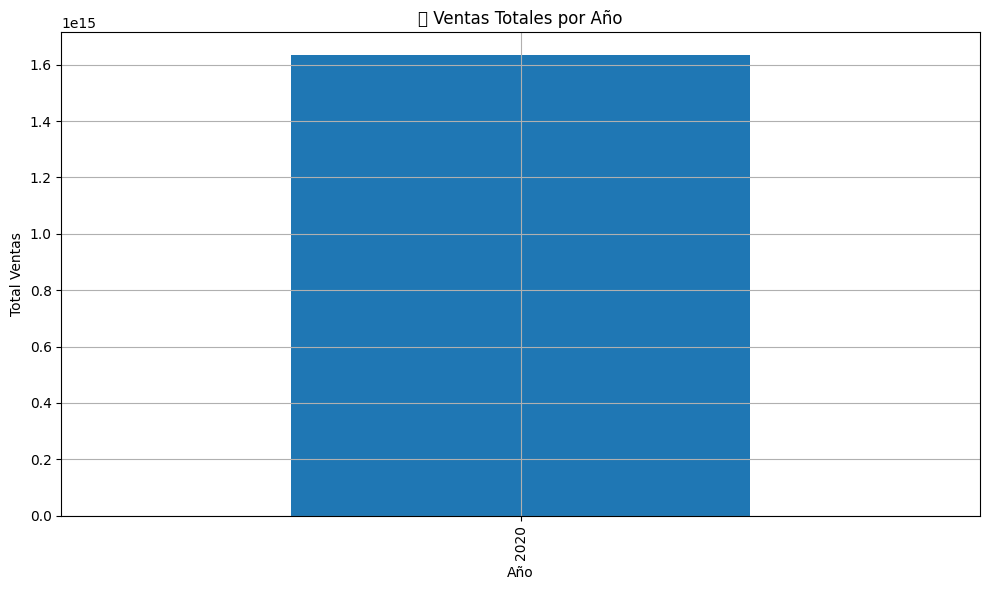

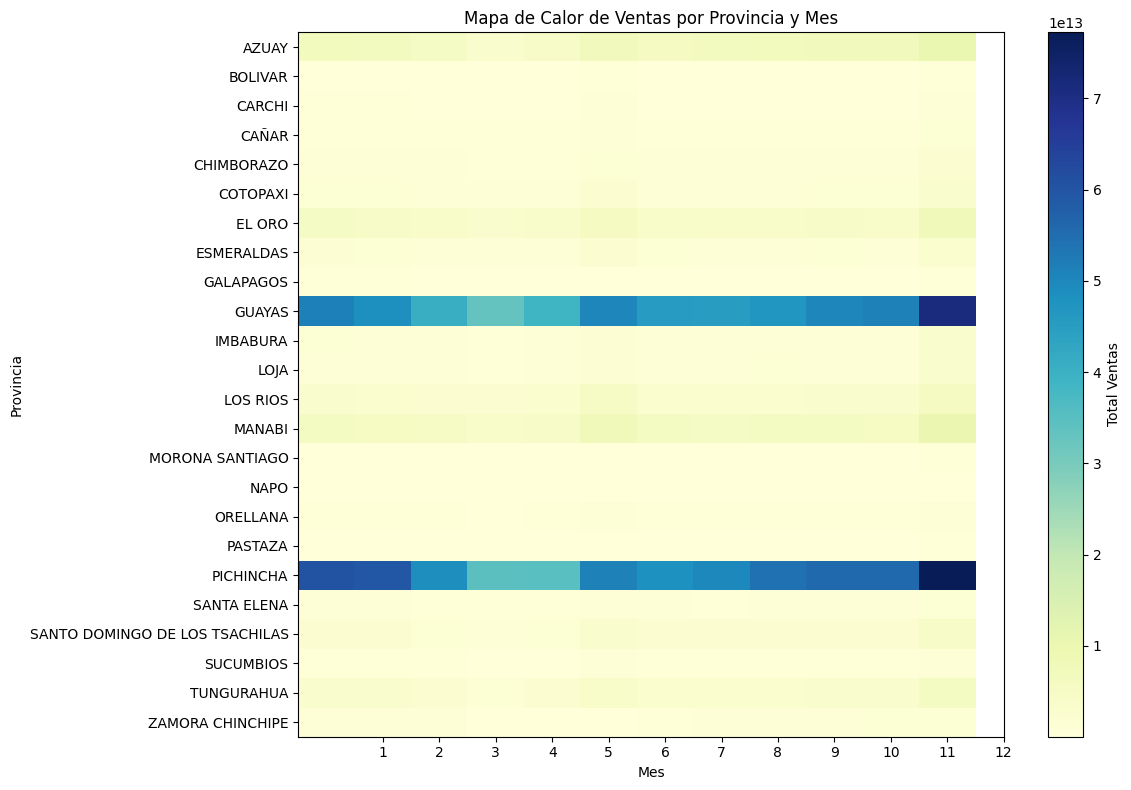

/tmp/ipython-input-21-3246454406.py:41: UserWarning: Glyph 128717 (\N{SHOPPING BAGS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128717 (\N{SHOPPING BAGS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


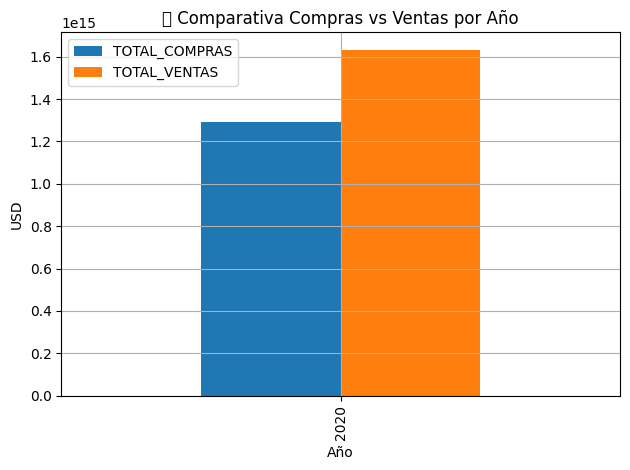

/tmp/ipython-input-21-3246454406.py:53: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


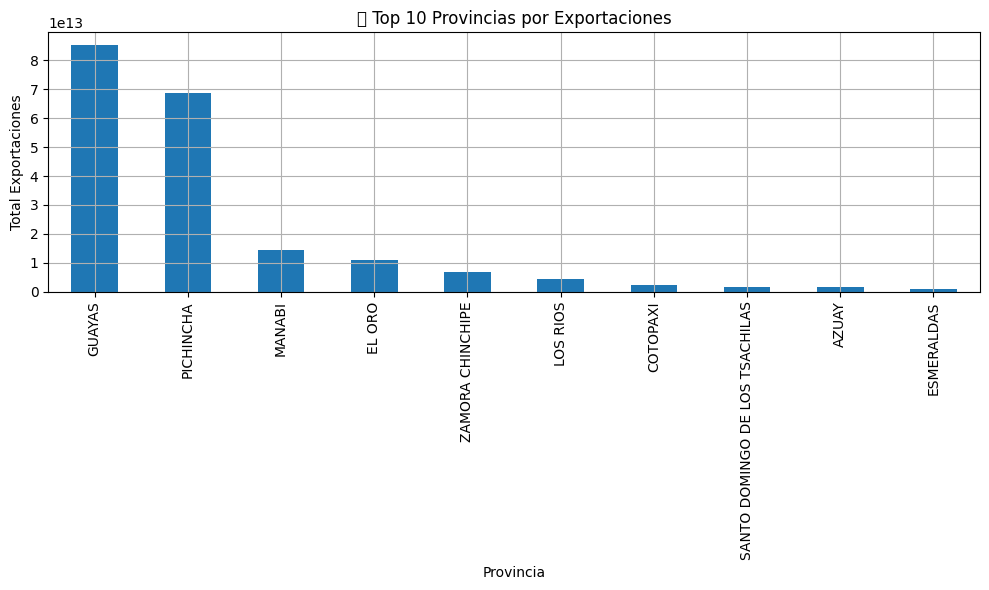

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Asegúrate de tener el DataFrame 'df' ya preparado con la columna FECHA

# 1. Total de ventas por año
ventas_anuales = df.groupby('AÑO')['TOTAL_VENTAS'].sum()

plt.figure(figsize=(10, 6))
ventas_anuales.plot(kind='bar')
plt.title("🛒 Ventas Totales por Año")
plt.ylabel("Total Ventas")
plt.xlabel("Año")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Mapa de calor: ventas por provincia y mes
ventas_heatmap = df.pivot_table(index='PROVINCIA', columns='MES', values='TOTAL_VENTAS', aggfunc='sum')

plt.figure(figsize=(12, 8))
plt.imshow(ventas_heatmap, aspect='auto', cmap='YlGnBu')
plt.colorbar(label="Total Ventas")
plt.xticks(ticks=range(1, 13), labels=range(1, 13))
plt.yticks(ticks=range(len(ventas_heatmap.index)), labels=ventas_heatmap.index)
plt.title("Mapa de Calor de Ventas por Provincia y Mes")
plt.xlabel("Mes")
plt.ylabel("Provincia")
plt.tight_layout()
plt.show()

# 3. Comparativa de compras vs ventas por año
compras_vs_ventas = df.groupby('AÑO')[['TOTAL_COMPRAS', 'TOTAL_VENTAS']].sum()

plt.figure(figsize=(10, 6))
compras_vs_ventas.plot(kind='bar')
plt.title("🛍️ Comparativa Compras vs Ventas por Año")
plt.ylabel("USD")
plt.xlabel("Año")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Top 10 provincias por exportaciones totales
top_exportaciones = df.groupby('PROVINCIA')['EXPORTACIONES'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_exportaciones.plot(kind='bar')
plt.title("🌍 Top 10 Provincias por Exportaciones")
plt.ylabel("Total Exportaciones")
plt.xlabel("Provincia")
plt.grid(True)
plt.tight_layout()
plt.show()

